In [1]:
from hrr import hrri, convolve, LTM
import numpy as np
import random
import time
import math
import matplotlib
import matplotlib.pyplot as plt

from rl import *
from agent import RlAgent
from utils import display_progress, train

Using TensorFlow backend.
/home/david/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/david/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/david/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/david/.local/lib/python3.7/site-packages/

# 1D Maze

This problem requires the agent to locate the goal within a 1D maze. The maze will be of some size *n*, indicating the possible number of positions/states. Given a position *x*, the position to the left is *x-1*, and the position to the right is *x+1*. The maze is also cyclical, so position *0* is adjacent to position *n-1*.

This notebook contains several different variants of the 1D maze problem.

# Maze Agent Definitions

These are the maze agents defined. Each problem is designed to accept *any* given RL approach.

## Standard Maze Agent

Set a goal position and the agent will learn to find it using the given TD-learning algorithm. This is the most basic variation of the problem and is used as a learning proof-of-concept.

In [3]:
class MazeAgent(RlAgent):
    
    def __init__(self, rl, mazeSize, goal):
        super(MazeAgent, self).__init__(rl)
        self.__size = mazeSize
        self.__goal = goal
        self.__visits = np.zeros(mazeSize)
        
    def onBegin(self, state, startState = None):
        if startState() is not None:
            state(startState)
        else:
            state(random.randrange(self.__size))
        
    def onStep(self, state):
        if self.stepCount() > 0:
            self.reward(-1.0, absorb=False)
        action = self.predict(f"s{state()}", ("left", "right"))
        if action == 0:
            state((state() - 1) % self.__size)
        else:
            state((state() + 1) % self.__size)
    
    def onFinish(self, state):
        if state() == self.__goal and self.stepCount() > 0:
            self.reward(0.0)
        return self.stepCount()
    
    def isAtGoal(self, state):
        return state() == self.__goal
    
    def epsilon(self, state):
        self.__visits[state()] += 1
        return 1/math.sqrt(self.__visits[state()])        

## N-task Maze Agent

Rather than learning to solve a single goal, this agent can learn to solve multiple goals, provided it is given some indication of which goal to solve. While the agent doesn't *know* where the goal is, the goal is used to encode an HRR vector that is convolved with the current maze position in this implementation.

In [3]:
class NMazeAgent(RlAgent):
    
    def __init__(self, rl, mazeSize):
        super(NMazeAgent, self).__init__(rl)
        self.__size = mazeSize
        
    def onBegin(self, state = None, goal = None, goals = (0,)):
        if goal() is None:
            goal(goals()[random.randrange(len(goals()))])
        if state() is None:
            state(random.randrange(self.__size))
        
    def onStep(self, state, goal):
        if self.stepCount() > 0:
            self.reward(-1.0, absorb=False)
        action = self.predict(f"s{state()}*g{goal()}", ("left", "right"))
        if action == 0:
            state((state() - 1) % self.__size)
        else:
            state((state() + 1) % self.__size)
    
    def onFinish(self, state, goal):
        if state() == goal() and self.stepCount() > 0:
            self.reward(0.0)
        return self.stepCount()
    
    def isAtGoal(self, state, goal):
        return state() == goal()

## Working Memory Maze Agent

This agent can solve a maze that contains multiple goals as before; but this agent utilizes working memory to do so. By giving the signal for the goal only at the very beginning of the episode, the agent will be require to *remember* this signal in order to find it. This is one of the basic demonstrations of the working memory concept.

In [4]:
class WmMazeAgent(RlAgent):
    
    def __init__(self, rl, mazeSize):
        super(WmMazeAgent, self).__init__(rl)
        self.__size = mazeSize
        self.actions = tuple('*'.join((m, d)) for m in ("protect", "store") for d in ("left", "right"))
        
    def onBegin(self, state = None, goal = None, goals = (0,), wm = None):
        if goal() is None:
            goal(goals()[random.randrange(len(goals()))])
        if state() is None:
            state(random.randrange(self.__size))
        
    def onStep(self, state, goal, wm):
        if self.stepCount() > 0:
            self.reward(-1.0, absorb=False)
        stateConv = self.stateConv(state, goal, wm)
        action = self.predict(stateConv, self.actions)
        self.move(state, action)
        self.updateWm(action, goal, wm)
    
    def onFinish(self, state, goal):
        if state() == goal() and self.stepCount() > 0:
            self.reward(0.0)
        return self.stepCount()
    
    def isAtGoal(self, state, goal):
        return state() == goal()
    
    def stateConv(self, state, goal, wm):
        conv = f"s{state()}"
        if self.stepCount() == 0: # The signal is on
            conv += f"*g{goal()}"
        if wm(): # There is a value in WM
            conv += f"*{wm()}"
        return conv
    
    def move(self, state, action):
        if action & 1: # Right
            state((state() + 1) % self.__size)
        else:
            state((state() - 1) % self.__size)
            
    def updateWm(self, action, goal, wm):
        if action & 2: # The action requests to store
            wm(f"g{goal()}_i" if self.stepCount() == 0 else None)

# Problem Solving

Below are some problem solving examples using the maze implementations defined above.

## Global Options

In [5]:
# Hard limit number of moves for a single episode
STEP_LIMIT = 100

## Utility Functions

In [6]:
def trainAgent(agent, *args, nEpochs=0, epsilon=0, simLimit=STEP_LIMIT, **kwargs):
    """Train the given agent for a fixed number of epochs"""
    s = time.time()
    for i in range(1, nEpochs+1):
        steps = agent.train(*args, epsilon=epsilon, simLimit=simLimit, **kwargs)
        display_progress((i)/nEpochs, f"Epoch: {i}/{nEpochs}")
    print(f"{agent.epoch()} took {time.time()-s:.2f} seconds")
    
def trainAgentConverge(agent):
    """Train the given agent until it can solve optimally"""
    pass

def plot(title, width, data, labels):
    t = np.arange(0, width+1, 1)
    fig, ax = plt.subplots()
    for i in range(len(data)):
        ax.plot(t, data[i], 'o-', label=labels[i])
    ax.set(xlabel='Position (s)', ylabel='Expected Reward Q(s, a)',
           title=title)
    ax.grid()
    plt.legend()

## Standard Maze Agent

In [22]:
# Maze Settings
MAZE_SIZE = 20
GOAL      = 10

# Agent Settings
HRR_SIZE   = 64
LEARN_RATE = 0.05
EPSILON    = 0.1
DISCOUNT   = 0.95

# Q-learning Agent
ql = NQLearningNetwork(1, HRR_SIZE, learnRate = LEARN_RATE, discountFactor = DISCOUNT)
qlAgent = MazeAgent(ql, MAZE_SIZE, GOAL)

# Double Q-learning Agent
dql = NQLearningNetwork(2, HRR_SIZE, learnRate = LEARN_RATE, discountFactor = DISCOUNT)
dqlAgent = MazeAgent(dql, MAZE_SIZE, GOAL)

Epoch: 960/960
Progress: [####################] 100.00%
1920 took 36.13 seconds


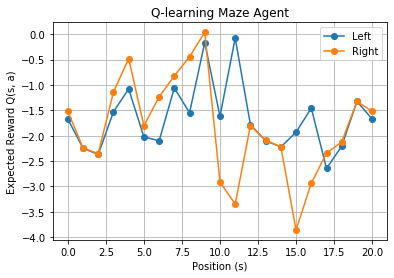

In [24]:
trainAgent(qlAgent, nEpochs=960, epsilon=EPSILON, simLimit=STEP_LIMIT)
l = [ql.value(f"s{(i%MAZE_SIZE)}", "left") for i in range(MAZE_SIZE+1)]
r = [ql.value(f"s{(i%MAZE_SIZE)}", "right") for i in range(MAZE_SIZE+1)]
plot("Q-learning Maze Agent", MAZE_SIZE, (l, r), ("Left", "Right"))

In [10]:
trainAgent(dqlAgent, nEpochs=5000, epsilon=EPSILON, simLimit=STEP_LIMIT)
l = [dql.averageValue(f"s{(i%MAZE_SIZE)}", "left") for i in range(MAZE_SIZE+1)]
r = [dql.averageValue(f"s{(i%MAZE_SIZE)}", "right") for i in range(MAZE_SIZE+1)]
plot("Double Q-learning Maze Agent", MAZE_SIZE, (l, r), ("Left", "Right"))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Epoch: 66/5000
Progress: [--------------------] 1.32%
Traceback (most recent call last):
  File "/home/david/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-9c23bbcc3961>", line 1, in <module>
    trainAgent(dqlAgent, nEpochs=5000, epsilon=EPSILON, simLimit=STEP_LIMIT)
  File "<ipython-input-7-4fd953e07e17>", line 5, in trainAgent
    steps = agent.train(*args, epsilon=epsilon, simLimit=simLimit, **kwargs)
  File "/home/david/Development/Jupyter/Research Methods/Research Project/agent.py", line 89, in train
    result = self.run(epsilon, simLimit, *args, **kwargs)
  File "/home/david/Development/Jupyter/Research Methods/Research Project/agent.py", line 104, in run
    self.onStep(*stepArgs)
  File "<ipython-input-3-0a8d15a3a933>", line 18, in onStep
    action = self.predict(f"s{state()}", ("left", "right"))
  File "/home/david/Development/Jupyter/Research Met

KeyboardInterrupt: 

# N-task Maze Agent

In [1]:
# Maze Settings
MAZE_SIZE = 20
GOALS = (2, 10, 17)

# Agent Settings
HRR_SIZE   = 2048
LEARN_RATE = 0.05
EPSILON    = 0.1
DISCOUNT   = 0.95

# Q-learning Agent
# Shown to converge with Size=10, HRR=1024, Learn=1, Epsilon=0.2, Discount=0.5
# Shown to converge with Size=20, HRR=1024, Learn=0.05, Epsilon=0.3, Discount=0.75, ~3k epochs
ntaskQl = NQLearningNetwork(1, HRR_SIZE, learnRate = LEARN_RATE, discountFactor = DISCOUNT)
ntaskQlAgent = NMazeAgent(ntaskQl, MAZE_SIZE)

# Double Q-learning Agent
ntaskDql = NQLearningNetwork(2, HRR_SIZE, learnRate = LEARN_RATE, discountFactor = DISCOUNT)
ntaskDqlAgent = NMazeAgent(ntaskDql, MAZE_SIZE)

NameError: name 'NQLearningNetwork' is not defined

Epoch: 4500/4500
Progress: [####################] 100.00%
5000 took 72.03 seconds


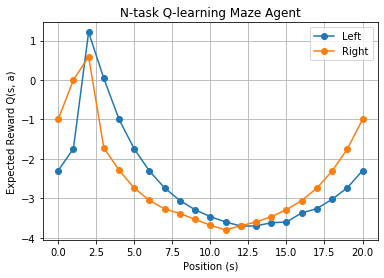

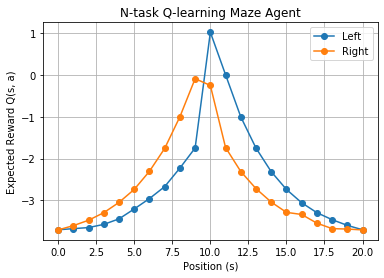

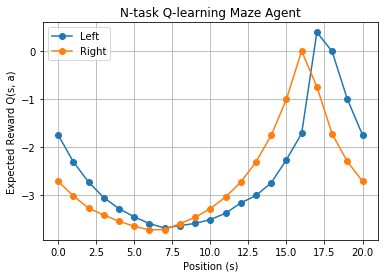

In [46]:
trainAgent(ntaskQlAgent, goals=GOALS, nEpochs=4500, epsilon=EPSILON, simLimit=STEP_LIMIT)
for goal in GOALS:
    l = [ntaskQl.value(f"s{(i%MAZE_SIZE)}*g{goal}", "left") for i in range(MAZE_SIZE+1)]
    r = [ntaskQl.value(f"s{(i%MAZE_SIZE)}*g{goal}", "right") for i in range(MAZE_SIZE+1)]
    plot("N-task Q-learning Maze Agent", MAZE_SIZE, (l, r), ("Left", "Right"))

Epoch: 5000/5000
Progress: [####################] 100.00%
5000 took 106.67 seconds


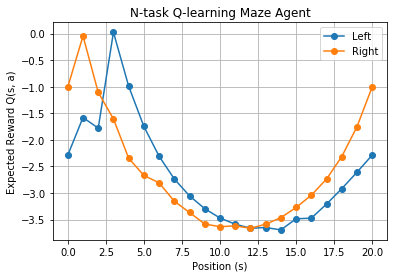

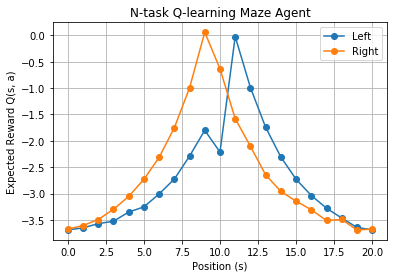

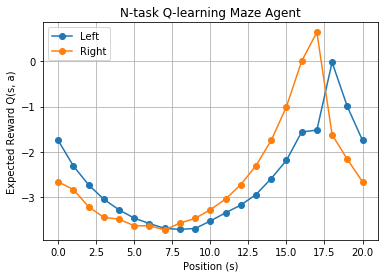

In [47]:
trainAgent(ntaskDqlAgent, goals=GOALS, nEpochs=5000, epsilon=EPSILON, simLimit=STEP_LIMIT)
for goal in GOALS:
    l = [ntaskDql.averageValue(f"s{(i%MAZE_SIZE)}*g{goal}", "left") for i in range(MAZE_SIZE+1)]
    r = [ntaskDql.averageValue(f"s{(i%MAZE_SIZE)}*g{goal}", "right") for i in range(MAZE_SIZE+1)]
    plot("N-task Q-learning Maze Agent", MAZE_SIZE, (l, r), ("Left", "Right"))

# Working Memory 1D-Maze

In [18]:
# Maze Settings
MAZE_SIZE = 20
GOALS = (0, 10)

# Agent Settings
HRR_SIZE   = 4096
LEARN_RATE = 1.0
EPSILON    = 0.05
DISCOUNT   = 0.75

# Q-learning Agent
# Shown to converge with Size=10, Learn=1, HRR=4096, Epsilon=0.3, Discount=0.5
# Shown to converge with Size=20, Learn=1, HRR=4096, Epsilon=0.25, Discount=0.75
wmQl = NQLearningNetwork(1, HRR_SIZE, learnRate = LEARN_RATE, discountFactor = DISCOUNT)
wmQlAgent = WmMazeAgent(wmQl, MAZE_SIZE)

# Double Q-learning Agent
wmDql = NQLearningNetwork(2, HRR_SIZE, learnRate = LEARN_RATE, discountFactor = DISCOUNT)
wmDqlAgent = WmMazeAgent(wmDql, MAZE_SIZE)

In [ ]:
trainAgent(wmQlAgent, goals=GOALS, nEpochs=6000, epsilon=EPSILON, simLimit=STEP_LIMIT)

Epoch: 116/6000
Progress: [--------------------] 1.93%


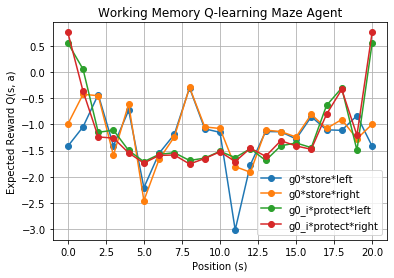

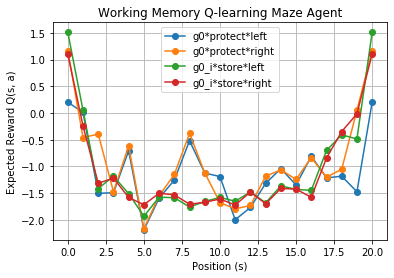

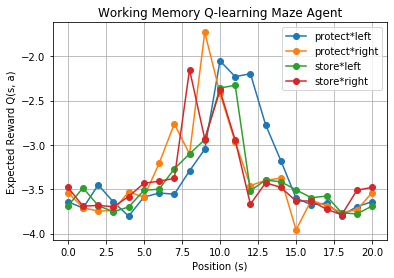

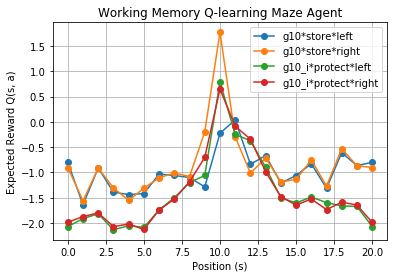

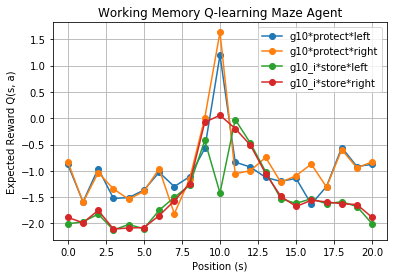

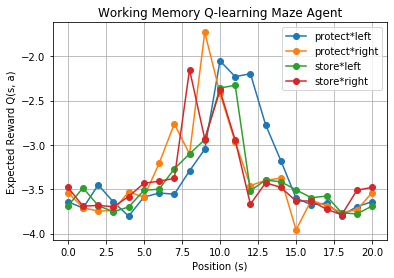

In [17]:
for goal in GOALS:
    for goalset in ((f"*g{goal}*store", f"*g{goal}_i*protect"), (f"*g{goal}*protect", f"*g{goal}_i*store"), ("*protect", "*store")):
        data, labels = [], []
        for goalr in goalset:
            for action in ("left", "right"):
                labels.append(f"{goalr[1:]}*{action}")
                data.append([wmQl.averageValue(f"s{i%MAZE_SIZE}{goalr}", action) for i in range(MAZE_SIZE+1)])
        plot("Working Memory Q-learning Maze Agent", MAZE_SIZE, data, labels)

In [11]:
GOALS = (0, 10)

trainAgent(wmDqlAgent, goals=GOALS, nEpochs=4000, epsilon=EPSILON, simLimit=STEP_LIMIT)

Epoch: 546/4000
Progress: [##------------------] 13.65%


KeyboardInterrupt: 

In [ ]:
trainAgent(wmDqlAgent, goals=GOALS, nEpochs=4000, epsilon=EPSILON, simLimit=STEP_LIMIT)
for goal in GOALS:
    for goalset in ((f"*g{goal}*store", f"*g{goal}_i*protect"), (f"*g{goal}*protect", f"*g{goal}_i*store"), ("*protect", "*store")):
        data, labels = [], []
        for goalr in goalset:
            for action in ("left", "right"):
                labels.append(f"{goalr[1:]}*{action}")
                data.append([wmDql.averageValue(f"s{i%MAZE_SIZE}{goalr}", action) for i in range(MAZE_SIZE+1)])
        plot("Working Memory Q-learning Maze Agent", MAZE_SIZE, data, labels)